# Model Development

Before publishing a model, the Data Scientist will research the data at hand and evaluate different model pipelines.

This notebooks simulates this process in an oversimplified manner. More will be added on an ongoing basis.

In [27]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

%matplotlib inline

In [28]:
#df = pd.read_csv('data/conversion.csv')

In [29]:
spark = SparkSession\
    .builder\
    .appName("PythonSQL")\
    .config("spark.hadoop.fs.s3a.s3guard.ddb.region","us-east-1")\
    .config("spark.yarn.access.hadoopFileSystems","s3a://demo-aws-1/")\
    .config("spark.hadoop.yarn.resourcemanager.principal",os.getenv("HADOOP_USER_NAME"))\
    .config("spark.executor.instances", 2)\
    .config("spark.executor.cores", 2)\
    .getOrCreate()

In [30]:
df = spark.read.option('inferschema','true').csv(
  "s3a://demo-aws-1/datalake/model_factory_demo",
  header=True,
  sep=',',
  nullValue='NA'
)

In [31]:
df.write.format('parquet').mode("overwrite").saveAsTable('default.historical_customer_interactions')

In [32]:
spark.sql("show tables").show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
| default|                   a|      false|
| default|           acct_data|      false|
| default|                  as|      false|
| default|             brancha|      false|
| default|             branchb|      false|
| default|    branch_intersect|      false|
| default|         caraccident|      false|
| default|             cc_data|      false|
| default|         dataanalyst|      false|
| default|               depts|      false|
| default|            dex_test|      false|
| default|                emps|      false|
| default|historical_custom...|      false|
| default|  lc_campaign_scores|      false|
| default|            lc_smote|      false|
| default|   lc_smote_complete|      false|
| default|         lc_smote_k2|      false|
| default|         lc_smote_k3|      false|
| default|            lc_table|      false|
| default|               micro| 

In [33]:
df = df.toPandas()

In [34]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [35]:
list(df['offer'].unique())

['Buy One Get One', 'No Offer', 'Discount']

In [36]:
df.shape

(64000, 9)

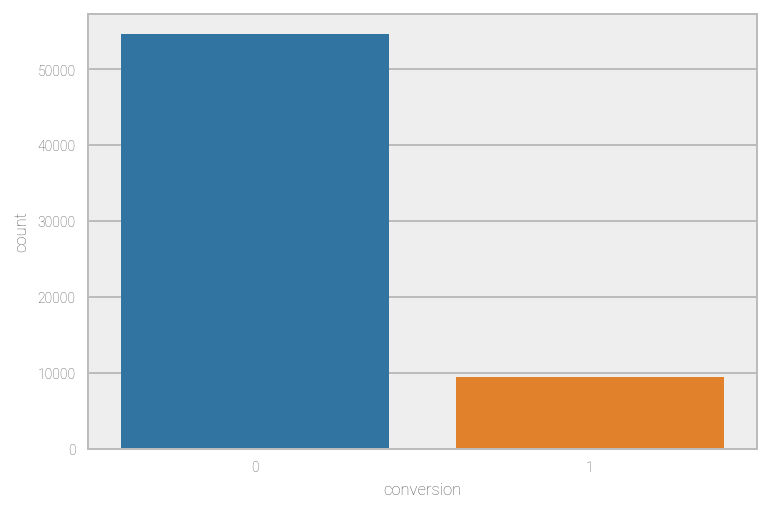

In [37]:
sns.countplot(df['conversion'])
plt.show()

In [38]:
df.dtypes

recency            int32
history          float64
used_discount      int32
used_bogo          int32
zip_code          object
is_referral        int32
channel           object
offer             object
conversion         int32
dtype: object

In [39]:
df['channel'].value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

In [40]:
df['offer'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64

In [41]:
#Let's convert categorical attributes to numerical types:

df = pd.get_dummies(df, columns=['channel', 'offer'], drop_first=True)

In [42]:
#We will drop zip code for now

df = df.drop(columns=['zip_code'])

In [58]:
X.columns

Index(['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
       'channel_Phone', 'channel_Web', 'offer_Discount', 'offer_No Offer'],
      dtype='object')

Model Training

In [43]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

In [44]:
y = df['conversion']
X = df.drop(columns=['conversion'])

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [46]:
clf = GradientBoostingClassifier(random_state=0)

In [47]:
clf.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [49]:
#probably overfitting... we'll add more in the future

clf.score(X_test, y_test)

0.854875

To Do Next:
    
    - Build a cross validation pipeline
    - Evaluate different models
    - Use upsampling to deal with class imbalance
    - Include feature engineering and selection
    - Use experiments to streamline the research process
    - Do the whole thing in Spark

Model Publishment

In [51]:
import pickle
from joblib import dump, load

In [52]:
s = pickle.dumps(clf)

In [53]:
dump(clf, 'models/clf.joblib') 

['models/clf.joblib']

In [56]:
spark.stop()